# Machine Learning Project 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import PIL
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm
from PIL import Image
from helper_func import load_image, PIL_resize, PIL_resize_ws
from matplotlib.pyplot import imshow


## Preprocess Image
Load the data from the dataset folder and resize the picture.


In [2]:
train = pd.read_csv('garbage-classification/zero-indexed-files.csv')
data = []
labels = train['Label'].values
for i in tqdm(range(train.shape[0])):
    img = load_image('garbage-classification/data/'+train['Name'][i]+'.jpg')
    img = PIL_resize_ws(img, 128)
    data.append(img)
data = np.asarray(data)
print("Training data size: ", data.shape)
print("Training label size: ", labels.shape)

100%|██████████| 2527/2527 [00:37<00:00, 66.90it/s]


Training data size:  (2527, 128, 128, 3)
Training label size:  (2527,)


## Training Data and Testing Data
We will randomly select a portion of data for training and using the rest of them for testing. We can change the ratio of $\frac{\text{training data}}{\text{testing data}}$ to improve the performance of our network.

In [3]:
num_classified = 6
classified_name = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]

classified_start_idx = np.zeros(num_classified, dtype=int)
classified_size = np.zeros(num_classified, dtype=int)
temp_count = 0
for i in range(num_classified):
    classified_start_idx[i] = temp_count
    size = np.count_nonzero(labels == i)
    classified_size[i] = size
    temp_count += size
    
print("Class name: ", classified_name)
print("Class start index:", classified_start_idx)

Class name:  ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
Class start index: [   0  501 1095 1498 1980 2390]


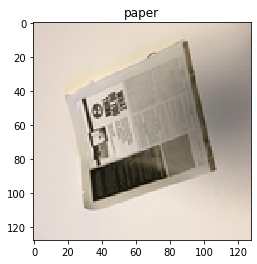

In [4]:
plt.figure()
display_idx = 1
plt.title(classified_name[display_idx])
imshow(data[classified_start_idx[display_idx]])

In [5]:
training_ratio = 0.9

training_data_size = np.array(training_ratio*classified_size, dtype=int)
testing_data_size = classified_size - training_data_size
print(classified_size)
print(training_data_size)
print(testing_data_size)

[501 594 403 482 410 137]
[450 534 362 433 369 123]
[51 60 41 49 41 14]


In [6]:
training_idx = np.array([], dtype=int)
testing_idx = np.array([], dtype=int)
for i in range(num_classified):
    selected = np.random.choice(classified_size[i],size=training_data_size[i],  replace=False)
    each = np.arange(classified_size[i])
    training_idx = np.concatenate((training_idx, selected+classified_start_idx[i]), axis=0)
    testing_idx = np.concatenate((testing_idx, np.setdiff1d(each, selected)+classified_start_idx[i]), axis=0)
training_idx = np.random.permutation(training_idx)
testing_idx = np.random.permutation(testing_idx)
print(training_idx)

[1568  817 2313 ... 1361 2267 1882]


In [7]:
def convert_to_one_hot(x, classes):
    one_hot = np.zeros((x.shape[0], classes), dtype=int)
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

In [8]:
labels = train['Label'].values
training_data = data[training_idx]
training_labels = labels[training_idx]
testing_data = data[testing_idx]
testing_labels = labels[testing_idx]
training_data = np.swapaxes(training_data, 1,3)
training_data = np.swapaxes(training_data, 2,3)
testing_data = np.swapaxes(testing_data, 1,3)
testing_data = np.swapaxes(testing_data, 2,3)

training_data = torch.from_numpy(training_data)
training_labels = torch.from_numpy(training_labels)
testing_data = torch.from_numpy(testing_data)
testing_labels = torch.from_numpy(testing_labels)
print("Training data shape: ", training_data.shape)
print("Training labels shape: ", training_labels.shape)
print("Testing data shape: ", testing_data.shape)
print("Testing labels shape: ", testing_labels.shape)

Training data shape:  torch.Size([2271, 3, 128, 128])
Training labels shape:  torch.Size([2271])
Testing data shape:  torch.Size([256, 3, 128, 128])
Testing labels shape:  torch.Size([256])


In [9]:
def create_batches(data, labels, batch_size=4):
    mini_batch_data = torch.split(data, batch_size, dim=0)[:-1]
    mini_batch_labels = torch.split(labels, batch_size, dim=0)[:-1]
    batches = []
    for i in range(len(mini_batch_data)):
        batches.append((mini_batch_data[i], mini_batch_labels[i]))    
    return batches

batch_size = 4
training_batches = create_batches(training_data, training_labels, batch_size)
testing_batches = create_batches(testing_data, testing_labels, batch_size)

## Neural Network Architecture

In [10]:
class Net(nn.Module):
    def __init__(self, batch_size=4, height=192, width=256):
        super(Net, self).__init__()
        kernel_size = 9
        self.batch_size = batch_size
        
        self.pool = nn.MaxPool2d(3)
        
        self.conv1 = nn.Conv2d(3, 48, kernel_size=kernel_size, padding=(kernel_size//2))
        self.conv2 = nn.Conv2d(48, 128, kernel_size=kernel_size, padding=(kernel_size//2))
#         self.conv3 = nn.Conv2d(192, 288, kernel_size=kernel_size, padding=(kernel_size//2))
        
        self.fc1 = nn.Linear(128*14*14, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, num_classified)

        
    def forward(self, x):
        x = self.pool((F.relu(self.conv1(x))))
        x = self.pool((F.relu(self.conv2(x))))
#         x = self.pool((F.relu(self.conv3(x))))
#         print(x.shape)

        x = x.view(-1, 128*14*14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
#         x = self.fc3(x)

        return x
    
net = Net(batch_size=batch_size, height=training_data.shape[2], width=training_data.shape[3])

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [ ]:
running_loss = 0.0
epoch = 0
display_loss = []

debug = False

for i in tqdm(range(len(training_batches))):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = training_batches[i]
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)

    loss = criterion(outputs, labels)
    
    if debug: # debug mode
        a = list(net.parameters())[0].clone()
        loss.backward()
        optimizer.step()
        b = list(net.parameters())[0].clone()
        print(torch.equal(a.data, b.data))
#         print(a.data - b.data)
#         print("a",a.data)
#         print("b",b.data)
    else:
        loss.backward()
        optimizer.step()

    # print statistics
    running_loss += loss.item()
    
    print_batches = 50
    if i % print_batches == (print_batches-1):    # print every 50 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / print_batches))
        display_loss.append(running_loss / print_batches)
        running_loss = 0.0
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

plt.figure()
plt.ylabel("loss")
plt.plot(np.arange(len(display_loss)), display_loss)


  9%|▉         | 50/567 [01:16<12:54,  1.50s/it]

[1,    50] loss: 1.790


 18%|█▊        | 100/567 [02:42<09:39,  1.24s/it]

[1,   100] loss: 1.789


 26%|██▋       | 150/567 [03:44<09:36,  1.38s/it]

[1,   150] loss: 1.788


 35%|███▌      | 200/567 [04:50<09:06,  1.49s/it]

[1,   200] loss: 1.788


 44%|████▍     | 250/567 [05:56<05:31,  1.05s/it]

[1,   250] loss: 1.787


 53%|█████▎    | 300/567 [06:55<04:55,  1.11s/it]

[1,   300] loss: 1.784


 62%|██████▏   | 350/567 [07:50<04:01,  1.11s/it]

[1,   350] loss: 1.783


 71%|███████   | 400/567 [08:46<03:08,  1.13s/it]

[1,   400] loss: 1.781


 78%|███████▊  | 440/567 [09:32<02:33,  1.21s/it]

Network structure:

In [ ]:
print(net)

In [ ]:
import torchvision
net.load_state_dict(torch.load(PATH))
display_idx = 45

t1, t2 = testing_batches[display_idx]
image_grid = np.swapaxes(torchvision.utils.make_grid(t1, padding=10), 0,2)
image_grid = np.swapaxes(image_grid, 0,1)
imshow(image_grid)

outputs = net(t1)
print(outputs)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classified_name[t2[j]]
                              for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classified_name[predicted[j]]
                              for j in range(4)))


## Testing the accuracy

In [ ]:
correct_match = 0
test_size = len(testing_batches) * batch_size

testing_ground_truth = np.array([], dtype=int)
testing_predict = np.array([], dtype=int)
for i in range(len(testing_batches)):
    data, labels = testing_batches[i]
    outputs = net(data)
    _, predicted = torch.max(outputs, 1)
    
    testing_ground_truth = np.concatenate((testing_ground_truth, labels), axis=0)
    testing_predict = np.concatenate((testing_predict, predicted), axis=0)
    
    matches = np.intersect1d(predicted, labels)
    correct_match += len(matches)
accuracy = correct_match/test_size
print("Testing Accuracy: ", accuracy)

## Generate the Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from helper_func import generate_confusion_matrix

generate_confusion_matrix(testing_ground_truth, testing_predict, classified_name)
plt.show()